# Mini-project 05 Background

Wed, Nov 30, 2022 (for mini-project due Dec 7)



## *Physics background: Partial Differential Equations (PDEs)*

When a function depends on more than one variable, it is called a multivariable function (https://en.wikipedia.org/wiki/Multivariable_calculus). The derivatives of such functions are called partial derivatives, because we can now define the derivatives with respect to one or more of the variables (https://en.wikipedia.org/wiki/Partial_derivative). 

The notation that specifies the derivative of a multivariable function with respect to one variable (among many) uses the curly derivative sign, $\partial$. For instance the partial derivative of $f(x,y)$ relative to x is written: $\partial f/\partial x$.

In many physical systems, the evolution over time and space is the solution of one or several differential equations involving partial derivatives. These often mix first and second order partial derivatives. Two important examples are the wave equation and the diffusion equation. Here we will look at the diffusion equation in detail, and look at how it can be solved numerically (https://en.wikipedia.org/wiki/Diffusion_equation).

We'll start by considering diffusion in one dimension. The diffusion equation in one dimension is given by:

$$\frac{\partial C(x,t)}{\partial t}=D \frac{\partial^2 C(x,t)}{\partial x^2},$$

in which $C(x,t)$ gives the concentration of a solute in a solution, as a function of position and time. Here we can imagine a solution of liquid inside a long thin capillary. There is some initial (t=0) concentration profile, $C(x,0)$ that defines the starting point of the evolution described by this equation.

Since `solve_ivp()` was designed to solve ordinary differential equations only, it can't be used here. There are python packages available to help solve partial differential equations like this, but here you will discretize the differential equation (make it discrete) and write code to solve it yourself.

To fully define the problem, we need both the ***initial conditions***, $C(x,0)$, and the ***boundary conditions***, which specify what happens at the edges of the region: what happens at $C(0,t)$ and $C(L,t)$? There are several common options:

* Absorbing boundary conditions: we set $C(0,t)$ and $C(L,t)$ to $0$, which means that any particles that diffused to the edge of the capillary are absorbed by the boundary and disappear from the solution. 
* Periodic boundary conditions: we used these in the Ising model problem. In this problem, periodic boundaries correspond to particles reaching one edge ($0$ or $L$) and reappearing at the other edge ($L$ or $0$). Periodic boundary conditions are useful if you want to pretend that the system is much larger than your actual simulation region. They make the edges 'disappear'. 
* Neumann (or reflecting) boundary conditions:	the derivative $\partial C/\partial x$ is specified (usually $= 0$) on the boundary. Here the particles that diffuse up to the boundary bounce off, and are reflected back into the solution.

We will use reflecting boundary conditions for this mini-project



#### Discretizing our Partial Differential Equation
To evolve the system under the diffusion equation, we first discretize the time derivative, approximating

$$\frac{\partial C}{\partial t} \approx \frac{C(x,t+\Delta t)-C(x,t)}{\Delta t},$$

so that the diffusion equation can be written as:

$$C(x,t+\Delta t) - C(x,t) = \Delta t \, D \frac{\partial^2 C}{\partial x^2},$$
$$C(x,t+\Delta t) = C(x,t) + \Delta t \, D \frac{\partial^2 C}{\partial x^2}.$$

This shows how we'll calculate new values of $C(x)$. At each time step, the next distribution $C(x)$ is equal to the old distribution, with a small change added to it that depends on the spatial derivative of $C$. To go further, we need a way to approximate $\partial^2 C/\partial x^2$. One can approximate a _first derivative_ of a function $f$ with:

$$\frac{df}{dx} \approx \frac{f(x+h)-f(x)}{h}.$$

It would then follow that the _second derivative_ can be approximated by:

$$\frac{d^2 f}{dx^2} \approx \frac{\frac{\displaystyle f(x+h)-f(x)}{\displaystyle h}-\frac{\displaystyle f(x)-f(x-h)}{\displaystyle h}}{h},$$
$$= \frac{f(x+h) + f(x-h) - 2 f(x)}{h^2}.$$

So our diffusion equation, in one dimension, becomes:

$$C(x,t+\Delta t) = C(x,t) + \Delta t \, D \frac{C(x+\Delta x,t) + C(x-\Delta x,t) - 2 C(x,t)}{\Delta x^2}.$$

The following code is a python implementation of this equation, with reflecting boundary conditions. It shows the initial blob of concentrated molecules in the middle of the capillary gradually spreading out uniformly over the entire length.

_Note the following, which provide a practical method to implement reflecting boundary conditions in discrete space:_
* If we have a discrete one-dimensional box with 10 grid locations, we add an additional 'phantom' grid location on either side of of the box, for a total of 10 + 1 +1 = 12 grid locations: x = 0 is the left phantom grid point, x = 1 to 10 are the actual grid points we care about, and x = 11 is the right phantom grid point. 
* With this configuration, the actual boundaries at the edges of our box lie in between x = 0 and x = 1 on the left, and between x = 10 and x = 11 on the right.
* When we apply the diffusion equations above, we apply them to the points x = 1 to x = 10, inclusive, with the phantom grid points providing the extra concentration information needed to apply the diffusion equation at the x = 1 and x = 10 locations.
* After applying the diffusion equations, we update the point x = 0 to contain the same concentration information as x = 1 and the point x = 11 to have the same concentration information as x = 10 so that $\partial C/\partial x = 0$ holds at the edges of our box.

initial and final integrals of concentration: 10.00 and 10.00


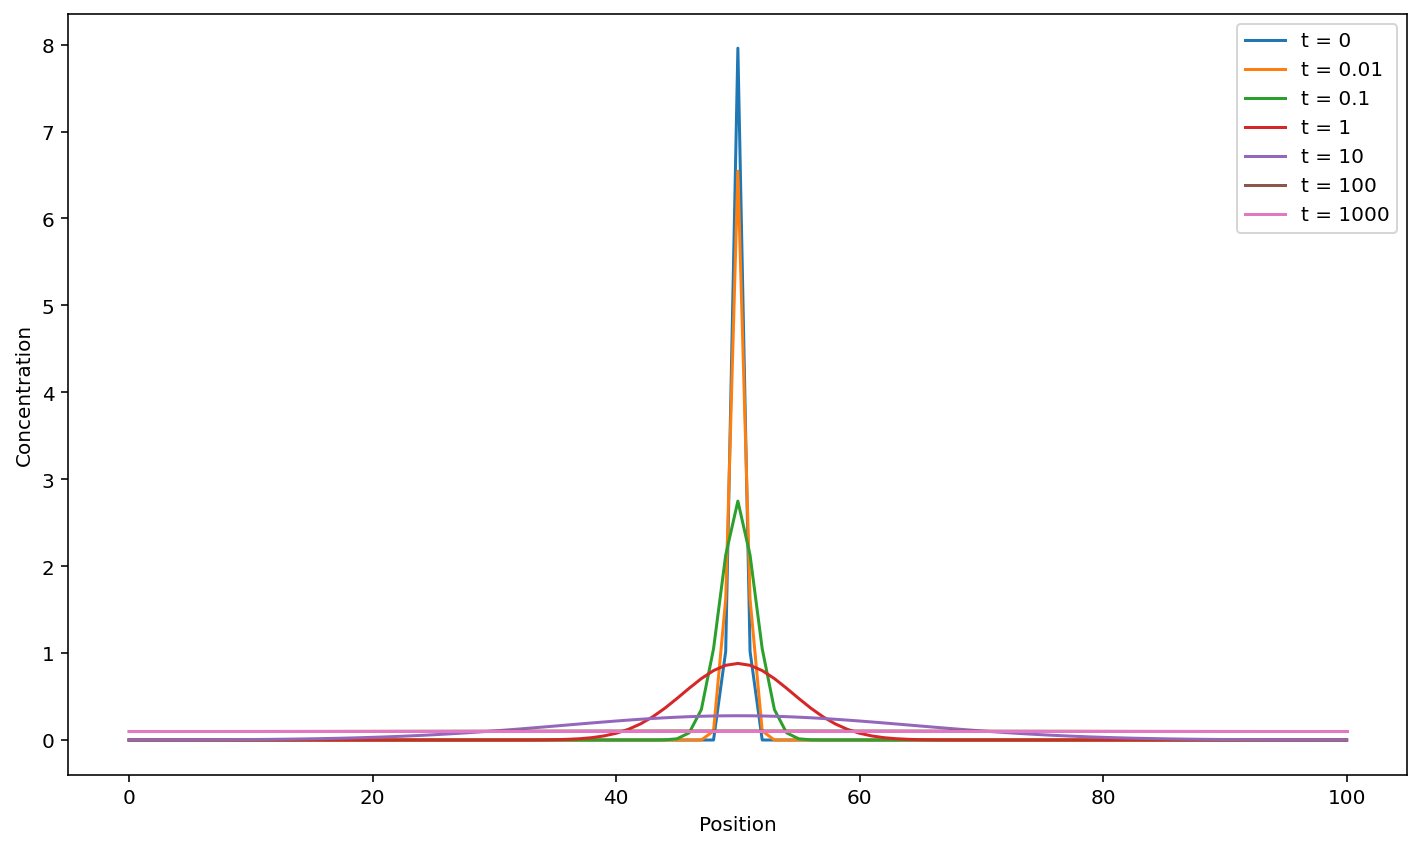

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants:
L = 1  # Size of 'box'
D = 1e-3
# We will include the phantom grid perimeter in our number of points
# to minimize additional complicated bookkeeping
N = 101

dt = 1e-2
dx = L / N

tmax = 1000
steps = int(tmax / dt) + 1

# Choose some times to make plots, given in step numbers:
plotsteps = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
plotsteps /= dt
plotsteps = plotsteps.astype(int)

# Create initial conditions:
C = np.zeros(N)

# Set particles in a blob in the center:
C[N // 2] = 10

# Our initial number of particles is the sum of C across
# all of our non-phantom grid points
isum = np.sum(C[1:-1])
k = dt / dx / dx * D

# C-prime (the concentrations after each time step)
Cp = np.zeros(N)

for i in range(steps):

    # Implement the diffision equation at all non-phantom grid points:
    for j in range(N - 2):
        Cp[j + 1] = C[j + 1] + k * (C[j] + C[j + 2] - 2 * C[j + 1])

    # The phantom grid points are just reflections of their neighbours
    # on the other side of the boundary (to maintain dC/dx = 0):
    Cp[0] = Cp[1]
    Cp[-1] = Cp[-2]

    # Update C to be Cp and then Cp will get overwritten on the next loop:
    C, Cp = Cp, C
    if i in plotsteps:
        plt.plot(C, label="t = %g" % (i * dt))

# If the boundary conditions are done correctly, the number of particles
# (the integral of C), should be constant. Check:
esum = np.sum(C[1:-1])
print("initial and final integrals of concentration: {:.2f} and {:.2f}".format(isum, esum))

plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()

#### Convergence
The analysis of convergence in numerical techniques like this is an important subject, though beyond the scope of this course. As a very brief introduction: once the scheme for the computation has been chosen, the granularity of the grid in both space and time is the main driver of the convergence and the final accuracy. 

One simple way to check that your numerical solution is not massively misbehaving due to convergence issues is to reduce the step sizes (e.g., dx and/or dt) by small amounts. If the computations are behaving, the result of the computation should smoothly change as the step sizes are changed. If instead you see huge, non-monotonic changes (large jumps) in the solution as the step size is gradually changed, you've probably got convergence problems. This is not a foolproof method to find convergence problems, but its a useful way to start looking for them. For a little more detail on convergence, have a look at:

* http://home.uni-leipzig.de/~physik/sites/mona/wp-content/uploads/sites/3/2017/04/differentiation-chap.pdf

In general you'd like to keep the step sizes as small as possible to increase the accuracy of your result, but this costs in computing time. In making step sizes larger, there is often a threshold above with the solution simply stops behaving qualitatively correctly.

It can be seen that if $dt$ is changed from $1 \times 10^{-2}$ to $1 \times 10^{-1}$, the solution diverges immediately.

/var/folders/rg/hh4cb_xd5_74c2r0hymqq4jm0000gn/T/ipykernel_29345/808707093.py:35: RuntimeWarning: overflow encountered in double_scalars
  Cp[j + 1] = C[j + 1] + k * (C[j] + C[j + 2] - 2 * C[j + 1])
/var/folders/rg/hh4cb_xd5_74c2r0hymqq4jm0000gn/T/ipykernel_29345/808707093.py:35: RuntimeWarning: invalid value encountered in double_scalars
  Cp[j + 1] = C[j + 1] + k * (C[j] + C[j + 2] - 2 * C[j + 1])


initial and final integrals of concentration: 10.0 nan


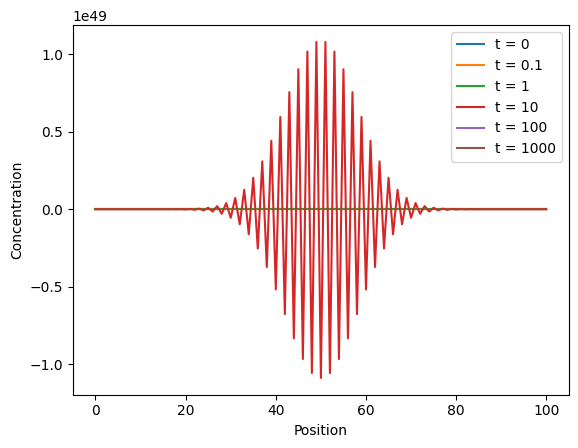

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Constants:
L = 1  # Size of 'box'
D = 1e-3
N = 101  # Number of grid points in 1D

### We reduced dt to 1e-1 here ###
dt = 1e-1
dx = L / N

tmax = 1000
steps = int(tmax / dt) + 1

# Choose some times to make plots, given in step numbers:
plotsteps = np.array([0.001, 0.01, 0.1, 1, 10, 100, 1000])
plotsteps /= dt
plotsteps = plotsteps.astype(int)

# Create initial conditions:
C = np.zeros(N)

# Set particles in a blob in the center:
C[N // 2] = 10
isum = np.sum(C) # Using this later
k = dt / dx / dx * D

Cp = np.zeros(N)

for i in range(steps):

    # Do all the points, except the boundaries:
    for j in range(N - 2):
        Cp[j + 1] = C[j + 1] + k * (C[j] + C[j + 2] - 2 * C[j + 1])
    # And the boundaries:
    Cp[0] = Cp[1]
    Cp[-1] = Cp[-2]

    # Swap C and Cp so that they don't end up as the same array:
    C, Cp = Cp, C
    if i in plotsteps:
        plt.plot(C, label="t = %g" % (i * dt))

# If the boundary conditions are done well, the number of particles
# (the integral of C), should be constant. Check:
esum = np.sum(C)
print("initial and final integrals of concentration:", isum, esum)

plt.xlabel('Position')
plt.ylabel('Concentration')
plt.legend()
plt.show()

## *Project overview*
For this mini-project you will consider the diffusion equation in a two-dimensional square dish, where the concentration of dye molecules obeys the diffusion equation:

$$\frac{\partial C(x,y,t)}{\partial t}=D (\frac{\partial^2 C(x,y,t)}{\partial x^2} + \frac{\partial^2 C(x,y,t)}{\partial y^2} ).$$

The concentration $C(x,y,t)$ is a function of three variables (two of space and one of time). The goal of the project is to write a program which solves this equation numerically. Doing a reliable and efficient job of these kinds of problems is an area of active research, and is behind many physics problems that we would like to be able to describe with computers. A famous example is the solution to the Navier-Stokes equation which describes the motion of fluids, and is used extensively by atmospheric scientists, oceanographers, and meteorologists, amongst others.

## *Objectives*

You will write a program that will calculate the solution $C(x,y,t)$ for a  system with the following parameters:

* A square dish with a thin layer of water in it (a 1x1 box with 101 grid points in each direction, including phantom grid points on either side),
* A drop of concentrated dye is added to the center of the dish and diffuses outward with D = 0.001. 
* Use a timestep of 0.01 s and . 
* At t=0, the point in the center of the dish should have C = 10 and all other points have C=0. 
* The boundaries are all reflecting, so that no particles escape.

Your program should:

1. Implement the diffusion equation for this two-dimensional system as was done in the example above for the one-dimensional system.
2. Produce an animation that shows the evolution of $C(x, y, t)$ over the time from t = 0 to 100 s. $C$ should be plotted as a heat map (`plt.pcolormesh` is good), and should contain one frame for every 0.2 s.
3. For approximately 30 times between 0.01 and 10 s, consider the one-dimensional profile of $C$ along the center, $C(x, L/2, t)$. 
   - Fit this profile at each of these times to a Gaussian curve, where the amplitude and standard deviation of the Gaussian are fit parameters. Here you are characterizing how spread out the concentration profile is at each of these time steps. To ensure that these fits are working as expected, it would be a good idea to temporarily make plots for some subset of these Gaussian fits. Do not keep these plots in the submitted version of your mini-project, they are only intended to help you with troubleshooting.
   - Plot the standard deviation of the Gaussian (from the fit) versus the _square root_ of the time, to see how this concentration profile spreads out over time. It would be good if these 30 times were somewhat evenly spaced when plotted as the square root of time. Theory predicts that the width should increase as $\sqrt{2Dt}$. Plot this line on top of your Gaussian standard deviation vs square root of time graph.
4. Make a plot of the total concentration/particle count $(\sum C(x,y))$ vs $t$. A measure of the total number of particles can be obtained from the sum of C(x,y,t) over all grid points.  If the differential equations and boundary conditions have been implemented correctly, this number should remain nearly constant (within a few percent of the initial value). If it is not, reducing the grid spacing or time step size may help.
5. In a new cell, make a copy of your program and experiment with the size of $dt$. How large can you make $dt$ and have the solution still converge? To figure this out, examine just the first 10 seconds of evolution so the program will run quickly. Write a couple of sentences describing: what happens to the animation when $dt$ is too large? What is the value of $dt$ where the simulation diverges? What is the value of $dt \, D/dx^2$ where the simulation starts to diverge? What happens to the sums you generate for Question 4 when the simulation diverges? To investigate the impact of the size of your grid, change your grid size to 51x51 points. Where is the divergence threshold for $dt$ on this smaller grid?

Hints:

1. It is probably easiest to do the animation with `pcolormesh` and `ArtistAnimation` (the style we used in Project 3)
1. You can do the calculations for the plots of questions 3 and 4 as the animation is being assembled, just store the values you need and make the plots in later cells.
1. The calculations themselves should be pretty quick here if implemented with array operations, but assembling the animation is slow. If you comment out the `animation.save()` and `HTML()` functions, the calculations are executed but the animation is not rendered. This will speed things up dramatically while you're working on it.
